(explainer_topic_model)=
hSBM Topic Modelling
==================

In this section we introduce part of our text analysis, namely the part which pertains to our topic modelling approach. Topic models are mainly used to cluster a collection of documents into different so-called 'topics'. In our analysis, we choose relevant topics, extract their topic distributions and visualize the results in different manners to demonstrate how and in which areas the different disciplines tend to interact on Wikipedia. 

In [21]:
# Imports
import os
import joblib
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import networkx as nx
import pandas as pd
import json
from IPython.display import display, Image, set_matplotlib_formats
import ast
from matplotlib import rc
plt.style.use('science')
set_matplotlib_formats('svg')
rc("text", usetex=False)

from pyvis.network import Network
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import from_networkx
from bokeh import palettes
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.models import Title
from bokeh import palettes
output_notebook()

/var/folders/81/hmpn7q9j37l5nqxjsd88rbf00000gn/T/ipykernel_19118/3714432809.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Loading BokehJS ...

In [14]:
# Load data
df = pd.read_pickle('Final_df.pickle')
new_names = list(zip(df.parent+ '-' + df.title))
new_names = [tuple[0] for index, tuple in enumerate(new_names)]

# hSBM data
topic_dist_df = pd.read_csv('topic_dist_df.csv')
topic_dist_df = topic_dist_df.drop('Unnamed: 0', axis = 1)
f = open('topics_l1.json')
topics_l1 = json.load(f) # topics at level 1 returning 20 most probable words
topics_l1 = {int(k):v for k,v in topics_l1.items()}

# network data 
word_nx = pd.read_csv('word_bipartite_df.csv')
word_nx = word_nx.drop('Unnamed: 0', axis = 1)
bipart_nx = pd.read_csv('bipartite_df.csv')
bipart_nx = bipart_nx.drop('Unnamed: 0', axis = 1)

### hierarchical Stochastic Block Model (hSBM) Topic Modelling 
Inspired by the approach set forth by {cite}`gerlach2018network`, we show the hierarchical clustering of documents and words from our Wikipedia dataset for all five scientific disciplines using a **hierarchical Stochastic Block Model** (hSBM). We only consider words that appear more than ten times in the text corpus and end up with 4302 articles or in our case, nodes. As opposed to other popular topic models such as LDA, we do not need to specify number of groups, levels or topics beforehand, since hSBM automatically detects these parameters. The model is inspired by community detection in networks and creates a bipartite-like network of words and documents. It splits the network into groups on different hierarchical levels organized as a tree. On each level, the hSBM clusters the documents and words in varying group sizes.

We have fed the model with data consisting of preprocessed tokens from each Wikipedia article where we remove infrequent tokens with a threshold at minimum 10 occurrences per token. We are able to extract the documents from the model using the document number which corresponds to the index from our dataframe. We have merged the title of each article with the discipline from which it originates i.e. 'Voter Turnout' becomes 'political_science-voter_turnout, which we need for the forthcoming analysis. The model has been trained in Google Colab due to resource limitations using the following code: 

```
# our text data
docs = df['tokens']

# remove infrequent words.
cutoff = 5
c = Counter()
for doc in docs:
    c.update(Counter(doc))
vocab = c.most_common(25000)
vocab = set([w for w,count in vocab if count>10])
# remove words 
docs = [[w for w in doc if w in vocab] for doc in docs]

# we create an instance of the sbmtm-class
model = sbmtm()

# we have to create the word-document network from the corpus
model.make_graph(docs,documents=['%d'%i for i in range(len(docs))])

# fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

# generate topics at level 1
topics_l1 = loaded_model.topics(l=1,n=20) 
```

We have experimented with extracting topics at different levels of the model (our model has 7 levels). Generally, we find that the topics at level 1 are the most cohesive and specific which is useful for our analysis. We specify that the model should return the 20 most probable words per topic (remember the model itself chooses a number of topics). The model generates 76 topics on level 1 which span from very method-related to more theme or topic-specific such as 'socialism' or 'US politics'. On level 2, we find 15 topics which are more discipline-related and broader. The lower the level, the less semantically cohesive the topics. We have exported the level 1 topics generated by the model from the colab notebook alongside the forthcoming visualisation and model parameters.

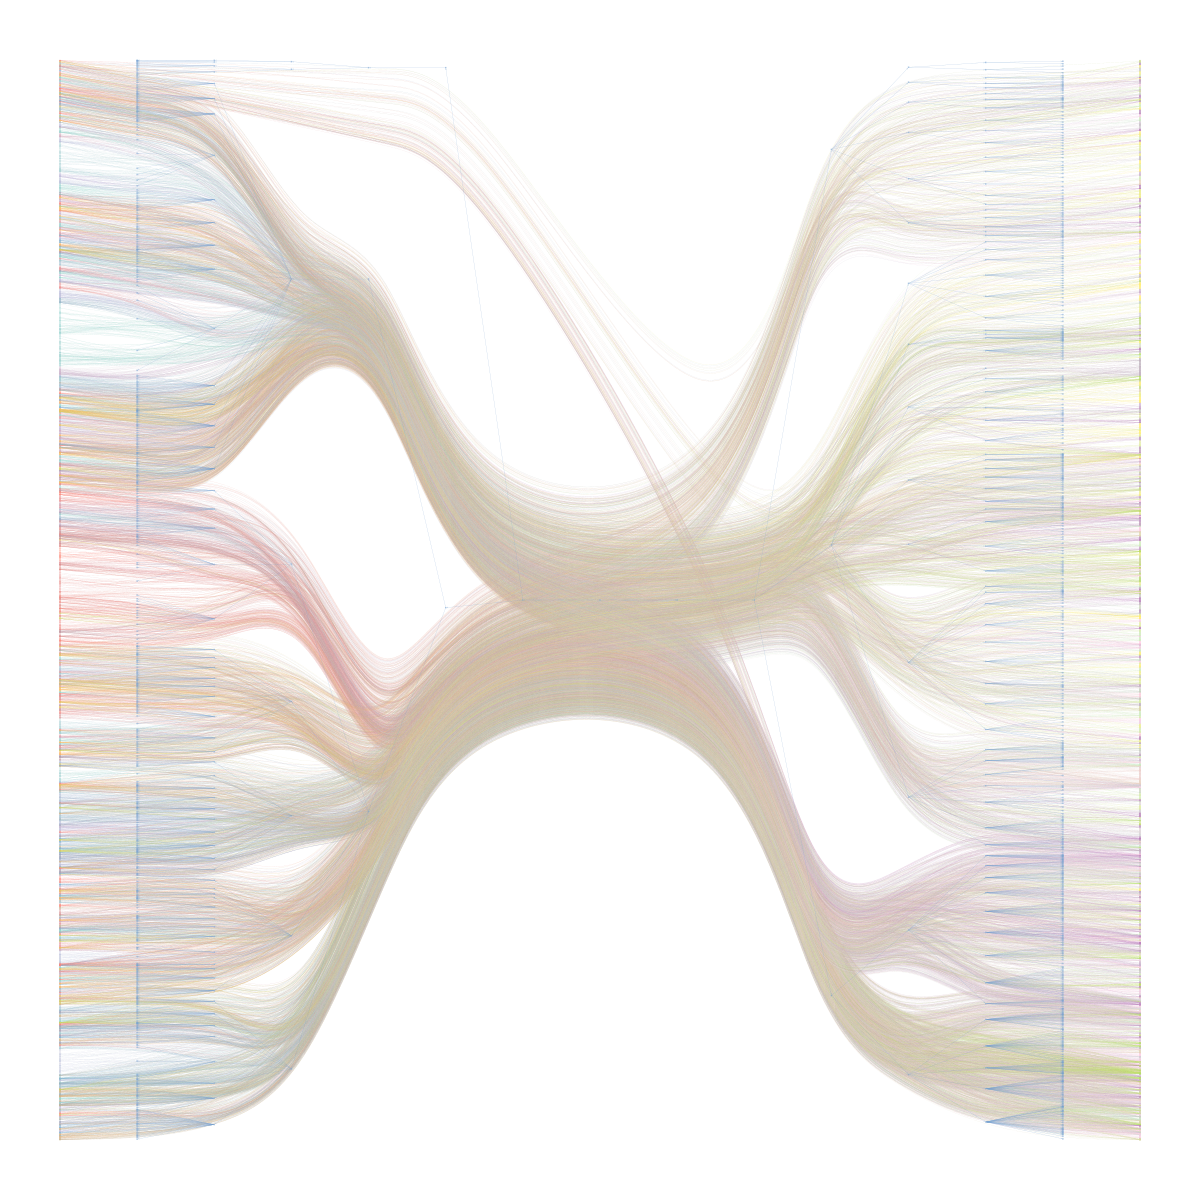

In [15]:
# plot of the model's hierarchical layers 
Image(filename = 'hSBM.png', width = 50, height = 20)

The above image shows the structure of the model. On the left side, we have the documents and on the right side, we see the words. Compared to Gerlach et al. 's visualisation (see link), we are not able to detect the different disciplines from this image, however we do find the division on the document-ax interesting as it seems to divide the documents into two overall sections. However we need a different approach to utilize this sort of model output, so instead we choose and name 10 topics from the level 1 topics for a deeper content analysis: 

In [4]:
# the 10 topics from level 1 of our model
chosen_topics = {'administrative_science':topics_l1[7], 'market_economy':topics_l1[18], 'museum_anthropology':topics_l1[23],
  'cognitive_psychology':topics_l1[25], 'academia':topics_l1[30], 'statistical_methods':topics_l1[32], 
   'socialism':topics_l1[43], 'labour_economics':topics_l1[53], 'class_racialization':topics_l1[68], 
  'US_politics_SoMe':topics_l1[75]}

# we create a pandas dataframe for our topics and topic words
topic_names = list(chosen_topics.keys())
topic_df = pd.DataFrame(index = topic_names)
topic_df['topics'] = list(chosen_topics.values())

The topics are chosen based on word clusters we find semantically meaningful and interesting for our query at hand - we choose some we believe to be purely discipline-specific and some which we believe to capture some overlap between disciplines. Our analysis will therefore touch upon patterns and tendencies rather than generalize across our entire dataset. We choose to visualize the word-topics with bar plots of the word probability distribution in each topic:

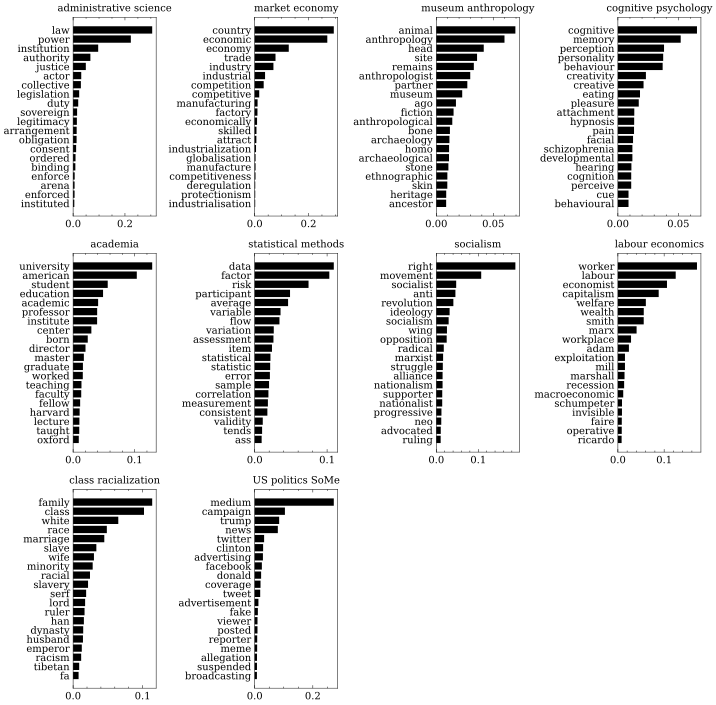

In [5]:
# Plot word probability distribution
fig, axs = plt.subplots(nrows = 3, ncols = 4,  figsize = (10,10), dpi = 300)
axs = axs.flat
fig.delaxes(axs[10])
fig.delaxes(axs[11])
for i in range(len(topic_df)):
    y = [i[0] for i in topic_df["topics"][i]][::-1]
    x = [i[1] for i in topic_df["topics"][i]][::-1]
    axs[i].barh(y, x, color = "k")
    axs[i].set_title(topic_df.index.tolist()[i].replace('_', ' '), fontsize = 10)
    axs[i].yaxis.set_ticks_position('none') 
plt.tight_layout()

From the words, we are already able to get a general idea of what kind of topic to infer. We see that especially the first 3 words of each topic tend to be very contributing. Based on our knowledge of the different disciplines, we are able to get an overall sense of whether we are dealing with an interdisciplinary topic such as 'statistical methods' or a disciplinary topic such as cognitive psychology. We do however want to be certain in our assessment and since words tend to be ambiguous, we extract the topic distribution for each chosen topic and their relation to articles in our corpus to better understand the context of the different words. The titles above each plot have been chosen based on both the word clusters as well as the articles related to each topic.

In [6]:
# function to extract the relevant data from our topic distributions
def get_topic_dist(key):
    
    # get the topic
    topic = topics_l1[key]
    # get the words belonging to each topic
    words = [tuple[0] for index, tuple in enumerate(topic)]
    # and their probabilities
    word_prob = [tuple[1] for index, tuple in enumerate(topic)]
    # get the 30 most probable articles related from the topic distribution
    topic_dist = topic_dist_df.iloc[key].sort_values(ascending = False)[:30]
    # store their probabilities
    article_probabilities = [t for t in topic_dist]
    # and their names
    articles = [t for t in topic_dist.index]
    
    return topic_num_names[key], article_probabilities, articles, words, word_prob

In [7]:
#new dict with original key values as keys and inferred topic as value
new_keys_names = list(chosen_topics.keys())
topic_num = [7, 18, 23, 25, 30, 32, 43, 53, 68, 75]
topic_num_names = dict(zip(topic_num, new_keys_names))

# lists of the different values we need 
topics = []
probabilities = []
article_names = []
words = []
word_prob = []

# extract all relevant values
for key in topic_num:
    element = get_topic_dist(key)
    topics.append(element[0])
    probabilities.append(element[1])
    article_names.append(element[2])
    words.append(element[3])
    word_prob.append(element[4])

Before diving further into our analysis, let us take a closer look at a few of the topics:

In [8]:
# the 20 most probable articles and words for this topic
topic0 = pd.DataFrame(list(zip(article_names[0], probabilities[0])), 
             columns = ['topic: administrative politics', 'probability'])
topic0[:20]

topic: administrative politics  probability
0             political_science-law_without_the_state     0.225806
1          political_science-exclusive_federal_powers     0.161017
2                            economics-economic_power     0.142857
3   political_science-the_province_of_jurisprudenc...     0.140000
4                 political_science-concurrent_powers     0.134021
5                     political_science-dualism_(law)     0.133492
6              political_science-political_obligation     0.130682
7                     political_science-retslægerådet     0.130435
8                     sociology-authority_(sociology)     0.126411
9                    political_science-implied_powers     0.119617
10                      sociology-delegated_authority     0.111111
11  political_science-institute_of_parliamentary_a...     0.108280
12                    political_science-universal_law     0.101695
13   sociology-tripartite_classification_of_authority     0.101190
14                       economics-hans-bernd_schäfer     0.100000
15  political_science-promulgation_(catholic_canon...     0.098876
16                    political_science-vacatio_legis     0.098726
17                             sociology-yhprum's_law     0.094488
18   political_science-list_of_national_legal_systems     0.093230
19                       economics-thrift_institution     0.090909

For topic 7, we infer it to regard administrative science. While the most probable words are 'law', 'power', and 'institution', we also see how the topic is the majority contributor in an overweight of political science documents which suggest the topic to be mainly political science-related. This topic is one of our more or less 'pure' discipline topics. Let's take a look at one of our more interdisciplinary topics: 

In [9]:
topic5 = pd.DataFrame(list(zip(article_names[5], probabilities[5])), 
             columns = ['topic: statistical methods', 'probability'])
topic5[:20]

topic: statistical methods  probability
0                political_science-total_survey_error     0.278846
1                political_science-non-sampling_error     0.271186
2                   economics-kitchen_sink_regression     0.218750
3              psychology-list_of_backmasked_messages     0.200000
4             economics-analysis_of_rhythmic_variance     0.170213
5                 psychology-psychological_statistics     0.166909
6                           economics-cash_flow_hedge     0.166667
7              political_science-administrative_error     0.166667
8                     economics-variance_risk_premium     0.161290
9                       economics-correlation_trading     0.148936
10               economics-truncated_regression_model     0.144068
11                           psychology-repeatability     0.141593
12                       economics-average_fixed_cost     0.140845
13                          economics-economic_puzzle     0.139535
14                psychology-reliability_(statistics)     0.137624
15  sociology-list_of_countries_by_share_of_income...     0.136364
16                     political_science-data_editing     0.135802
17                       economics-cost_accrual_ratio     0.135135
18          political_science-tim_holt_(statistician)     0.123711
19      political_science-scale_analysis_(statistics)     0.123711

Statistical methods is one of our most interdisciplinary topics as it is present in articles from multiple disciplines. We find in particular that articles from psychology, political science and economics are related to the topic suggesting that statistical methods is a topic of interdisciplinary character. Intuitively, this aligns with our understanding of the different disciplines as statistical inference and causality traditionally both are strived for in academic work from these fields and thus involve well-known methods related to this topic. 
    Since the distribution of Wikipedia articles between disciplines is skewed towards political science, we find many political science-related topics in general as well as articles in each topic. This will also be evident in the following section.

### Bipartite Network of 10 Topic and Related Articles

We wish to visualize the topics and their related articles in a bipartite network. The topics will be one type of nodes and the articles another type. Links represent articles connected to the given topic. The links are further weighted by the probabilities for an article to be contributing/explanatory of the topic. 

In [11]:
# list to hold the weights of the edges 
weighted_edge_list = [(edge.source, edge.target, edge.weight) for edge in bipart_nx.itertuples(index=False)]

# ready the data for our bipartite network 
node_attributes = pd.DataFrame(bipart_nx['source'].tolist() + bipart_nx['target'].tolist(), columns = ['node'])
node_attributes['category'] = node_attributes['node'].apply(lambda x: 'target' if x in bipart_nx['target'].tolist() else 'source')
node_attributes['discipline'] = list(node_attributes.node.apply(lambda x: x.split('-')[0]))
node_attributes['discipline'] = node_attributes['discipline'].apply(lambda x: 'topic' if x in node_attributes['node'].tolist() else x)
node_attributes.rename({'node_attr': 'discipline'}, axis=1, inplace=True)
node_attr = node_attributes.drop_duplicates(subset="node", keep="first").set_index("node").to_dict("index")

In [18]:
# Create the graph and set a positional algorithm
G = nx.Graph()
for i in range(len(weighted_edge_list)):
    n1, n2, w = weighted_edge_list[i][0], weighted_edge_list[i][1], weighted_edge_list[i][2]
    G.add_edge(n1, n2, weight = w)
    nx.set_node_attributes(G, node_attr)

positions = nx.spring_layout(G, seed=7)

In [19]:
# Same color palette as earlier nodebooks for the nodes
col_pal= {'anthropology': '#440154',
          'political_science': '#3B518A',
          'economics': '#208F8C',
          'psychology': '#5BC862',
          'sociology': '#FDE724',
          'topic': '#000000'}

def get_nodecolor_list_from_palette(G: nx.Graph, col_pal: dict=col_pal) -> list:
    """
    Creates a list of colors given the parent attribute of a node
    and its color defined in the color palette.
    """
    return [col_pal[G.nodes[i]["discipline"]] for i in G.nodes]

def get_edge_color_palette(G: nx.Graph) -> dict:
    """
    Creates a list of nuances of gray given the weight of a edge.
    Darker color = higher weight.
    """
    weights = set([round(G.get_edge_data(a,b)['weight'], 3) for a, b in G.edges()])
    col_edge_pal = palettes.gray(len(weights))
    col_edge_pal = {w: col_edge_pal[key] for key, w in enumerate(sorted(weights, reverse=True))}
    return col_edge_pal

col_edge_pal = get_edge_color_palette(G)

# Setting the edge colour attribute
edge_attrs = {}
for a,b in G.edges():
    edge_attrs[(a, b)] = col_edge_pal[round(G.get_edge_data(a,b)['weight'],3)]
    nx.set_edge_attributes(G, edge_attrs, "edge_color")

In [22]:
# Define tooltips
HOVER_TOOLTIPS = [("Page", "@index"),
                  ("Discipline", "@discipline")]

#Create a plot
plot = figure(tooltips=HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", 
              active_scroll='wheel_zoom')

# Add title
plot.add_layout(Title(text='Network of topics and their weighted links with pages', text_font_size="16pt"), 'above')

# Hide axis and gridlines
plot.axis.visible = False
plot.grid.grid_line_color = None

#Set positions, node size and color
G_interactive = from_networkx(G, positions, scale=1, center=(0, 0))
G_interactive.node_renderer.data_source.data['node_sizes'] = [(G.degree(node) + 15) * 0.50 for node in G.nodes()]
G_interactive.node_renderer.data_source.data['node_colour'] = get_nodecolor_list_from_palette(G)
G_interactive.node_renderer.data_source.data['alpha'] = [0.75 for node in G.nodes()]
G_interactive.node_renderer.glyph = Circle(
    size="node_sizes",
    fill_color="node_colour",
    fill_alpha = "alpha")

#Set edge color based on weigths
G_interactive.edge_renderer.glyph = MultiLine(line_color="edge_color")

plot.renderers.append(G_interactive)
show(plot)

Remember that each small node represents an article and each large node represents a topic. The links are created if they have been determined by the hSBM model to be related to the given topic. Each discipline has been given a distinct color and the edges have been weighted with the probabilities of the topic contributing to the given article. 

The plot testifies to the dominance of political science in our dataset however, we also see pure psychological and anthropological topics. The anthropological topic is interesting since it doesn't capture stereotypical topics within anthropology but rather captures the archaeological and historical part of the discipline. 

While we had expected to see more overlaps between articles across topics, this is merely a small subsample of the 76 topics which the model generated from the corpus. We do however see links between topics which are dominated by economics articles. The intersecting nodes are different lists of scholars or topics except one which pertains to economic power. We do not find these shared links to capture meaningful intersections between the chosen topics. It would have been interesting to look at all semantically cohesive topics from the model and see if more overlaps would be present. However, as the following section of our analysis will touch upon, the authors of the different Wikipedia articles do not seem to relate articles to other disciplines intentionally. 

**In summary:** Overall such an analysis can provide us with an understanding of language similarities across documents. It provides us with an overview of the distribution of disciplines within topics and thus an opportunity to look at possible intersections such as the statistical methods-topic. 